# Dimensionalidade

Esse termo se refere ao número de dimensões, ou seja, de descritores do nosso sistema. Por exemplo, se nossos dados são descritos por apenas duas quantidades, podemos demonstrar os dados em um gráfico bidimensional com dois eixos, assim, dizemos que nossos dados estão em um espaço de duas dimensões.

Em geral, quanto mais descritores temos para nossos dados, mais variância podemos explicar. Em outras palavras, maior a chance de que pequenas variações nos dados podem ser explicadas por diferentes descritores. Entretanto, se temos muitos descritores para poucos dados, corremos o risco de "modelar o erro", ou seja, as pequenas variações deixam de ter significado por se tratarem apenas de ruído. Com isso, existe o risco de criarmos modelos sobreajustados (overfitting) aos dados de treinamento, que não terão um bom desempenho em dados futuros.

Além disso, existe um fenômeno denominado "maldição da dimensionalidade", que ocorre quando trabalhamos com dados em muitas dimensões. Em resumo, dados em muitas dimensões ficam "esparsos", espalhados por esse espaço multidimensional, o que é um problema para modelos que dependem do cálculo de distâncias entre os pontos. Além disso, é impossível fazer uma amostragem representativa, já que existem muitas combinações possíveis entre as dimensões.

Dessa forma, quando temos poucos dados e muitos descritores, reduzir a dimensionalidade pode ser uma ferramenta interessante para melhorar a performance dos nossos modelos. Vejamos algumas formas de reduzir a dimensionalidade em um conjunto de dados de compostos e solubilidade (Delaney).

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("delaney-processed.csv")
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


Vamos desprezar os descritores disponíveis e usar o RDKit para calcular 200 descritores químicos para nosso conjunto de dados

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

names = [name[0] for name in Descriptors.descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
descs = [calc.CalcDescriptors(Chem.MolFromSmiles(cpd)) for cpd in df["smiles"]]
descriptors_df = pd.DataFrame(descs, columns=names)
descriptors_df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,0
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
descriptors_df.shape

(1128, 200)

Temos 200 descritores e 1128 compostos. Vamos separar um conjunto de treinamento e um de teste, treinar um modelo com todos os descritores e avaliar sua qualidade no conjunto de teste

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, 
                                                    df['measured log solubility in mols per litre'], 
                                                    test_size=0.25, 
                                                    random_state=0)

In [29]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento): ", mae_train)
print("Erro absoluto médio (teste): ", mae_test)

Erro absoluto médio (treinamento):  0.393
Erro absoluto médio (teste):  0.597


Agora, vamos aplicar diferentes métodos de redução de número de descritores e comparar os resultados.

## 1. PCA

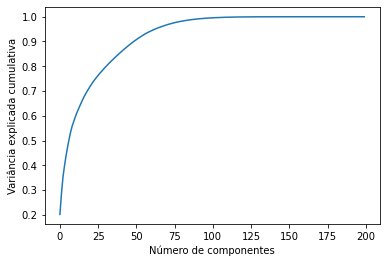

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# É necessário normalizar os dados antes de fazer uma PCA
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# Cálculo das componentes principais
pca = PCA()
pca.fit_transform(X_train_ss)

# Variância explicada
# fonte: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada cumulativa')
plt.show()

Veja que a partir de aproximadamente 75 componentes, já temos quase 100% da variância dos dados explicada. Vejamos como fica um modelo treinado com 25 componentes principais (75% da variância explicada).

In [27]:
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train_ss)
X_test_pca = pca.transform(X_test_ss)

reg = linear_model.LinearRegression()
reg.fit(X_train_pca, y_train)

y_pred_train = reg.predict(X_train_pca)
y_pred_test = reg.predict(X_test_pca)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento): ", mae_train)
print("Erro absoluto médio (teste): ", mae_test)

Erro absoluto médio (treinamento):  0.577
Erro absoluto médio (teste):  0.719


## 2. SelectKBest

## 3. Lasso